In [23]:
import os
import re
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms

import cv2
import cmapy
from scipy import ndimage

from utils_for_fusion import (
    inference_rgb_ir_frames,
    fuse_rgb_thermal_labels,
)


In [24]:
def get_id_from_path(path):
    base = os.path.basename(path)
    og_filename, extension = os.path.splitext(base)
    id = og_filename.split(" ")[-1]
    id = re.sub(r"[()]", "", id)
    return int(id)

In [25]:
# Load the rgb classification model
rgb_model_file = "../weights/rgb_resenet18_epoch-5_full_model.pth"
rgb_model = torch.load(rgb_model_file, map_location=torch.device("cpu"))

# Load the thermal classification model
thermal_model_file = "../weights/thermal_resenet18_epoch-5_full_model.pth"
thermal_model = torch.load(thermal_model_file, map_location=torch.device("cpu"))

class_names = ["NN", "YN", "YY"]
data_transforms = {
    "val": transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
}

In [26]:
# Load the rgb and thermal image pairs
# base_dir = "/Users/umar/UWaterloo/4B/Capstone4B/deep_learning/app/dataset_utils/rgb_ir_test_pairs"
base_dir = "/Users/umar/UWaterloo/4B/Capstone4B/deep_learning/app/dataset_utils/thermal_tests/ir_test_3"

rgb_base_dir = os.path.join(base_dir, "rgb")
ir_base_dir = os.path.join(base_dir, "ir")
rgb_list = [
    os.path.join(rgb_base_dir, i)
    for i in os.listdir(rgb_base_dir)
    if i.endswith(".jpg") or i.endswith(".png")
]
ir_list = [
    os.path.join(ir_base_dir, i) for i in os.listdir(ir_base_dir) if i.endswith(".jpg") or i.endswith(".png")
]
print("rgb_list:", rgb_list)
print("ir_list:", ir_list)
# fused_list = [
#     (rgb_path, ir_path, get_id_from_path(rgb_path))
#     for (rgb_path, ir_path) in zip(rgb_list, ir_list)
# ]
fused_list = [
    (rgb_path, ir_path, "YN")
    for (rgb_path, ir_path) in zip(rgb_list, ir_list)
]

rgb_list: ['/Users/umar/UWaterloo/4B/Capstone4B/deep_learning/app/dataset_utils/thermal_tests/ir_test_3/rgb/rgb_3.png', '/Users/umar/UWaterloo/4B/Capstone4B/deep_learning/app/dataset_utils/thermal_tests/ir_test_3/rgb/rgb_2.png', '/Users/umar/UWaterloo/4B/Capstone4B/deep_learning/app/dataset_utils/thermal_tests/ir_test_3/rgb/rgb_1.png']
ir_list: ['/Users/umar/UWaterloo/4B/Capstone4B/deep_learning/app/dataset_utils/thermal_tests/ir_test_3/ir/ir_1.png', '/Users/umar/UWaterloo/4B/Capstone4B/deep_learning/app/dataset_utils/thermal_tests/ir_test_3/ir/ir_3.png', '/Users/umar/UWaterloo/4B/Capstone4B/deep_learning/app/dataset_utils/thermal_tests/ir_test_3/ir/ir_2.png']


In [41]:
# inference one rgb thermal image pair and visualize the results
rgb_path, ir_path, label = fused_list[2]
print("rgb_path:", rgb_path)
print("ir_path:", ir_path)
print("label:", label)

rgb_img = Image.open(rgb_path)
ir_img = Image.open(ir_path)

rgb_path: /Users/umar/UWaterloo/4B/Capstone4B/deep_learning/app/dataset_utils/thermal_tests/ir_test_3/rgb/rgb_1.png
ir_path: /Users/umar/UWaterloo/4B/Capstone4B/deep_learning/app/dataset_utils/thermal_tests/ir_test_3/ir/ir_2.png
label: YN


In [42]:
def _process_raw_image(_raw_image, _interpolation_list, _interpolation_index, _colormap_list, _colormap_index, filter_image=False):
    """Process the raw temp data to a colored image. Filter if necessary"""
    # Image processing
    # Can't apply colormap before ndimage, so reversed in first two options, even though it seems slower
    if _interpolation_index==5:  # Scale via scipy only - slowest but seems higher quality
        _image = ndimage.zoom(_raw_image,25)  # interpolate with scipy
        _image = cv2.applyColorMap(_image, cmapy.cmap(_colormap_list[_colormap_index]))
    elif _interpolation_index==6:  # Scale partially via scipy and partially via cv2 - mix of speed and quality
        _image = ndimage.zoom(_raw_image,10)  # interpolate with scipy
        _image = cv2.applyColorMap(_image, cmapy.cmap(_colormap_list[_colormap_index]))
        _image = cv2.resize(_image, (800,600), interpolation=cv2.INTER_CUBIC)
    else:
        _image = cv2.applyColorMap(_raw_image, cmapy.cmap(_colormap_list[_colormap_index]))
        _image = cv2.resize(_image, (800,600), interpolation=_interpolation_list[_interpolation_index])
    _image = cv2.flip(_image, 1)
    if filter_image:
        _image=cv2.bilateralFilter(_image,15,80,80)
    return _image

def _c_to_f(temp:float):
    """ Convert temperature from C to F """
    return ((9.0/5.0)*temp+32.0)

def _add_image_text(use_f, _image, _temp_min, _temp_max, _interpolation_list_name, _interpolation_index, _colormap_list, _colormap_index, filter_image):
    """Set image text content"""
    if use_f:
        temp_min=_c_to_f(_temp_min)
        temp_max=_c_to_f(_temp_max)
        text = f'Tmin={temp_min:+.1f}F - Tmax={temp_max:+.1f}F - Interpolation: {_interpolation_list_name[_interpolation_index]} - Colormap: {_colormap_list[_colormap_index]} - Filtered: {filter_image}'
    else:
        text = f'Tmin={_temp_min:+.1f}C - Tmax={_temp_max:+.1f}C - Interpolation: {_interpolation_list_name[_interpolation_index]} - Colormap: {_colormap_list[_colormap_index]} - Filtered: {filter_image}'
    cv2.putText(_image, text, (30, 18), cv2.FONT_HERSHEY_SIMPLEX, .4, (255, 255, 255), 1)
    return _image

_colormap_list = ['jet','bwr','seismic','coolwarm','PiYG_r','tab10','tab20','gnuplot2','brg']
_interpolation_list = [cv2.INTER_NEAREST,cv2.INTER_LINEAR,cv2.INTER_AREA,cv2.INTER_CUBIC,cv2.INTER_LANCZOS4,5,6]
_interpolation_list_name = ['Nearest','Inter Linear','Inter Area','Inter Cubic','Inter Lanczos4','Pure Scipy', 'Scipy/CV2 Mixed']

rgb predicted label: YN
ir predicted label: YY


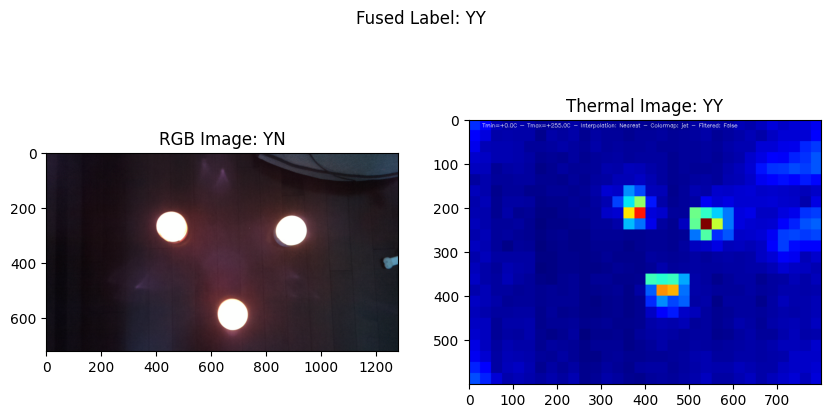

In [43]:
# visualize the results
rgb_img = Image.open(rgb_path)
ir_img = np.array(Image.open(ir_path))

processed_ir_image = _process_raw_image(ir_img, _interpolation_list, 0, _colormap_list, 0, filter_image=False)
_temp_min = np.min(ir_img)
_temp_max = np.max(ir_img)
processed_ir_image = cv2.cvtColor(processed_ir_image, cv2.COLOR_BGR2RGB)

rgb_label, ir_label = inference_rgb_ir_frames(
    rgb_model, thermal_model, data_transforms, class_names, rgb_img, Image.fromarray(processed_ir_image)
)

fused_label = fuse_rgb_thermal_labels(rgb_label, ir_label)

print("rgb predicted label:", rgb_label)
print("ir predicted label:", ir_label)

processed_ir_image = _add_image_text(False, processed_ir_image, _temp_min, _temp_max, _interpolation_list_name, 0, _colormap_list, 0, False)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(rgb_img)
ax[0].set_title(f"RGB Image: {rgb_label}")
ax[1].imshow(processed_ir_image)
ax[1].set_title(f"Thermal Image: {ir_label}")
fig.suptitle(f"Fused Label: {fused_label}")
plt.show()
